In [1]:
using Distributions
using LinearAlgebra
using Plots
using Random
using DelimitedFiles
using ForwardDiff
using HaltonSequences

In [2]:
uniform=Uniform(0,1);

In [6]:
ENV["JULIA_NUM_THREADS"] 

"6"

### In this case, both Af and Xstar are deterministic functions 

In [8]:
function Af(t)
    temp=1.0/((1.0.+σ^2).+σ^2*(T.-t)); 
    return temp 
end
function Xstar(t)
    denfrac=(σ^2.0.+1.0.+σ^2*T)./(1.0.+σ^2.0.+σ^2*(T.-t))
    temp=t.+(T.^2.0./(2*σ^2) -XT1./σ^2 )*log.(denfrac)
    return temp
end

function rt1(tvec,deno)
    return 0.5*(-tvec.^2).*deno
end

function rt1_v2(tvec)
    return 0.5*(-tvec.^2).*1.0./(1.0.+σ^2.0.+σ^2*(T.-tvec))
end

function denom(tvec)
    return 1.0./(1.0.+σ^2.0.+σ^2*(T.-tvec))
end

denom (generic function with 1 method)

## Not sure to keep 

tempts=zeros(NT); 
for i in collect(1:1:NT)
    # den_temp=denom(timeVec[i]); 
     tempts[i]=rt1_v2(timeVec[i]); 
end

In [9]:
# this matrix compute the inverse of the matrix of interest. 
function mainMat(x0,ntime)
    Nn=length(ntime); 
    mat=zeros(Nn+1,Nn+1); 
    bVec=zeros(Nn+1); 
    
    bprep=Xstar(ntime); 
    
    denr1=denom(ntime); 
    rvec=rt1(ntime,denr1); 
    
    tempX=zeros(Nn+1);
    ucontrol=zeros(Nn);   
    
    for i in collect(1:1:Nn)
        atemp=Af(ntime[i]);
        mat[i,i]=1.0 
        mat[i,i+1]=-1.0 
        mat[i,i:Nn]=mat[i,i:Nn].-atemp*dt2*ones(Nn-i+1)
        
        mat[i,end]=mat[i,end]-atemp*Δt; 
        
        bVec[i]=-(sum(bprep[i:Nn]))*atemp*dt2+rvec[i]*Δt
    end
    mat[Nn+1,1]=1.0;
    bVec[end]=copy(x0); 
    
    tempX=inv(mat)*bVec; 
    ucontrol=(tempX[2:end].-tempX[1:Nn])/Δt.+rvec[1:Nn] 
    return ucontrol
end

function ExactSol(x0,ntime)
    Nn=length(ntime); 
    xtemp=copy(x0); 
    control_output=zeros(Nn); 
    xVec=zeros(Nn+1); xVec[1]=x0; 
    
    
    for i in collect(1:1:Nn)
        timeloc=ntime[i:end];
        controln=mainMat(xtemp,timeloc)
        control_output[i]=controln[1]; 
        
        rval=rt1_v2(ntime[i]);  
        xtemp=xtemp.+ (controln[1]- rval) *Δt.+σ*controln[1].*Wfixed[i]*sqrtt;
        xVec[i+1]=xtemp; 
    end
    return control_output, xVec
end

ExactSol (generic function with 1 method)

In [10]:
uctrl=mainMat(0.0,timeVec);

LoadError: UndefVarError: timeVec not defined

# Numerical part for the problem

In [11]:
function fx(x,xs)
    l=x.-xs
    return l
end
function Xtraj(xinit_cloud,ntime,nU) 
    #nU has dim  × nN
    nN=length(ntime); 
    Xvec=zeros(nN+1);
    
    rp_index=rand(1:S)
    Xvec[1]=xinit_cloud[rp_index]
    Wvec=randn(nN);
    
    for i in collect(1:1:nN)
       # den_temp=denom(ntime[i]); 
        rval=rt1_v2(ntime[i]);    
        Xvec[i+1]=Xvec[i].+ (nU[i]-rval)*Δt.+σ*nU[i]*Wvec[i]*sqrtt; 
    end
    return Xvec,Wvec
end

function YZ(xvec,uvec,wvec,ntime)
    """
    Returns one backward sample according to the forward sample of X and the corresponding control. 
    """
    wvec_temp=wvec; 
    Nn=length(ntime);   #length(xvec); 
    
    ytemp=zeros(Nn+1); ztemp=zeros(Nn);    
    " according to our scheme, the terminal condition of yT is not 0 anymore "  
    ytemp[end]=xvec[end]; 
       
    for i in collect(Nn:-1:1)
        ztemp[i]=ytemp[i+1].*wvec_temp[i]/sqrtt; 
        ytemp[i]=ytemp[i+1].+Δt*(fx(xvec[i],Xstar(ntime[i])))
    end
    return ytemp,ztemp
end

function jcp(yvec,zvec,xvec,Uvec)
    Nn=length(Uvec);
    temp=zeros(Nn); 
    for i in collect(1:1:Nn)
        temp[i]=yvec[i]+σ*zvec[i]+Uvec[i]
    end
    return temp
end
    
function optimize_loc(xinit_cloud,ntime)
    nN=length(ntime); 
    Uvec=zeros(nN); 
# the threads are only distributed over the closest loop. 
Threads.@threads for i in collect(1:1:L) #  Threads.@threads 
        xvec,Wvec=Xtraj(xinit_cloud,ntime,Uvec); 
        yvec,zvec=YZ(xvec,Uvec,Wvec, ntime);
        Uvec=Uvec.-lr[i]*jcp(yvec,zvec,xvec,Uvec) #jPrime(yvec,Uvec)#.-0.05*jPrime(yvec,Uvec)
    end
    return Uvec
end

function particleDirect(timeVec)
    #U here plays the role of particle cloud
    Nn=length(timeVec)
    xtemp=copy(X0);
    
    controlVec=zeros(Nn)
    xtempVec=zeros(Nn+1)
    
    uvec0=zeros(S);
    
    for i in collect(1:1:Nn)
        timeloc=timeVec[i:Nn]; 
        
        controln=optimize_loc(uvec0,timeloc); #finding the control requires the particle cloud
        #collecting the control
        controlVec[i]=controln[1]; 
        
        rval=rt1_v2(timeVec[i]);  
        
        ### The exact movement
        xtemp=xtemp.+ (controln[1]- rval) *Δt.+σ*controln[1].*Wfixed[i]*sqrtt; 
        uvec0=ones(S)*xtemp;
        xtempVec[i+1]=xtemp
    end
    return xtempVec,controlVec
end

particleDirect (generic function with 1 method)

## Examine the correctness of solutions

The following plot shows that the SGD part of the solution is correct. 
The blue line is the solution obtained through the SGD algorithm, and the red line is the exact solution 
obtained via solving a coupled Forward-backward ODE system at each time. 

And it has been tested experimentally that using $L=5000$ gives an accurate approximation of the true solution.

In [12]:
function particleF(timeVec)
    #U here plays the role of particle cloud
    nN=length(timeVec)
    U=zeros(nN+1,S)
    Uhat=zeros(S)
    U[1,:]=X0.+0.05*randn(S);
    xtemp=copy(X0);
    
    controlVec=zeros(nN)
    
    for i in collect(1:1:nN)
        timeloc=timeVec[i:nN]; 
        
        controln=optimize_loc(U[i,:],timeloc); #finding the control requires the particle cloud
        #collecting the control
        controlVec[i]=controln[1]; 
        
        rval=rt1_v2(timeVec[i]);  
        
        ### The exact movement
        xtemp=xtemp.+ (controln[1]- rval) *Δt.+σ*controln[1].*Wfixed[i]*sqrtt; 
        Y_obs=sin.(xtemp).+0.1*Bfixed[i];  
        
        # Ensemble prediction
        Uhat=U[i,:].+(controln[1]- rval) *Δt.+σ*controln[1].*randn(S)*sqrtt;
        dvec=Y_obs.-sin.(Uhat) # find the ensemble difference
        
        #updating the weight of the particles
        what=exp.(-0.5.*(100*dvec.^2)) 
        weight=what./sum(what)
        
        #The resampling step: at the previous step, the weights are not uniform.
        ws=cumsum(weight)
        for p in collect(1:1:S)
            ix=findfirst(ws.>rand(uniform)); 
            U[i+1,p]=Uhat[ix]
        end
    end
    return U,controlVec
end
function particleF2(Xexact,timeVec)
    #U here plays the role of particle cloud
    
    nN=length(timeVec)
    U=zeros(nN+1,S)
    Uhat=zeros(S)
    U[1,:]=X0.+0.05*randn(S);
    xtemp=copy(X0);
    
    controlVec=zeros(nN)
    
    for i in collect(1:1:nN)
        timeloc=timeVec[i:nN]; 
        
        controln=optimize_loc(U[i,:],timeloc); #finding the control requires the particle cloud
        #collecting the control
        controlVec[i]=controln[1]; 
        
        rval=rt1_v2(timeVec[i]);  
        
        ### The exact movement
      #  xtemp=xtemp.+ (controln[1]- rval) *Δt.+σ*controln[1].*Wfixed[i]*sqrtt; 
        Y_obs=sin.(Xexact[i+1]).+0.1*Bfixed[i];  
        
        # Ensemble prediction
        Uhat=U[i,:].+(controln[1]- rval) *Δt.+σ*controln[1].*randn(S)*sqrtt;
        
        dvec=Y_obs.-sin.(Uhat) # find the ensemble difference
        
        #updating the weight of the particles
        what=exp.(-0.5.*(100*dvec.^2)) 
        weight=what./sum(what)
        
        #The resampling step: at the previous step, the weights are not uniform.
        ws=cumsum(weight)
        for p in collect(1:1:S)
            ix=findfirst(ws.>rand(uniform)); 
            U[i+1,p]=Uhat[ix]
        end
    end
    return U,controlVec
end

particleF2 (generic function with 1 method)

In [13]:
#uu,ccvec=particleF(timeVec);

In [25]:
NT=50; 
Δt=1.0/NT; dt2=(Δt)^2; 
timeVec=Δt*collect(0:1:NT-1); 
sqrtt=sqrt(Δt); 

T=1.0;
σ=0.1;
αT=log.(1.0+ σ^2/(1.0+σ^2)*T)/(σ^2+log.(1.0+ σ^2/(1.0+σ^2)*T)); 
XT1=T^2/2.0*αT;

S=512; # Size of the particle cloud 
X0=0.0; Xcloud=ones(S)*X0; 
Wfixed=randn(NT); Bfixed=randn(NT); 
L=2000; 
lr=1.0./collect(1:1:L);

## Examine the correctness of the SGD 

In [26]:
ctrlp1,p2=ExactSol(0.0,timeVec)
extemp,excont=particleDirect(timeVec);

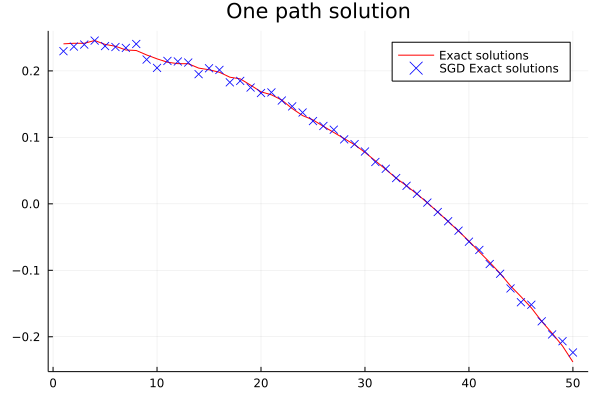

In [16]:
comp=plot(ctrlp1,color="red", label="Exact solutions"); 
scatter!(comp,excont,markershape=:xcross, markercolor="blue", label="SGD Exact solutions")
title!("One path solution")
#png(comp,"comp.png")

## Multi-core

In [17]:
ctrlp1,p2=ExactSol(0.0,timeVec)

([0.24074503278307594, 0.2415662251525701, 0.241546018797691, 0.24574513308236504, 0.23990729324049395, 0.23711253292794887, 0.23149146852836494, 0.23070243727275364, 0.22399710936190376, 0.21814987222309834  …  -0.07225664871638499, -0.08810607946204602, -0.10475060272183018, -0.12351453114086913, -0.13953912065288, -0.15645425442619054, -0.1768716264894209, -0.19471817705469563, -0.2138962461555336, -0.23793788023816115], [0.0, 0.00403111057749335, 0.008519517061688114, 0.00834087627850286, 0.01792955910702641, 0.024041477831445425, 0.03261863572707595, 0.03590861891000775, 0.04479088357923987, 0.05240808454611476  …  0.20646448609080917, 0.2118306189050898, 0.2189358210388185, 0.2228722145289506, 0.227306134527314, 0.23487524961808046, 0.23944542109745517, 0.2449579553261677, 0.2549800378581184, 0.2630946585803221])

In [33]:
uu,ccvec=particleF(timeVec);
xfilter_unob=mean(uu,dims=2)[:,1];

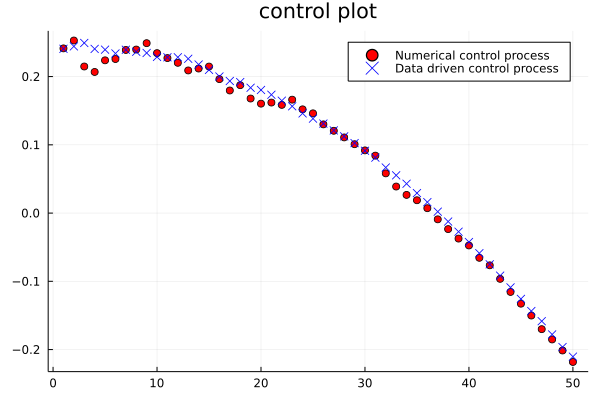

In [34]:
pp=scatter(ccvec,color="red",label="Numerical control process")
scatter!(pp,ctrlp1,markershape=:xcross,markercolor="blue",label="Data driven control process")
title!("control plot")
#png(pp,"fbcontrol_plots/dim1_control_S512.png")

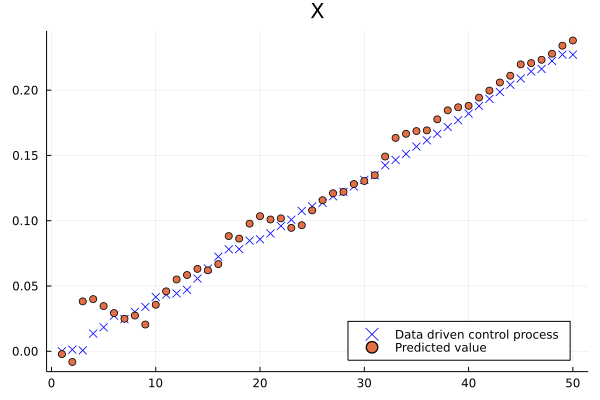

In [35]:
xpp=scatter(p2[1:NT],legend=:bottomright,markershape=:xcross,markercolor="blue",label="Data driven control process")
scatter!(xpp,xfilter_unob[1:NT],label="Predicted value")
title!("X")
#png(xpp,"fbcontrol_plots/dim1_X_S512.png")

## One core

In [ ]:
uu,ccvec=particleF(timeVec);
xfilter_unob=mean(uu,dims=2)[:,1];

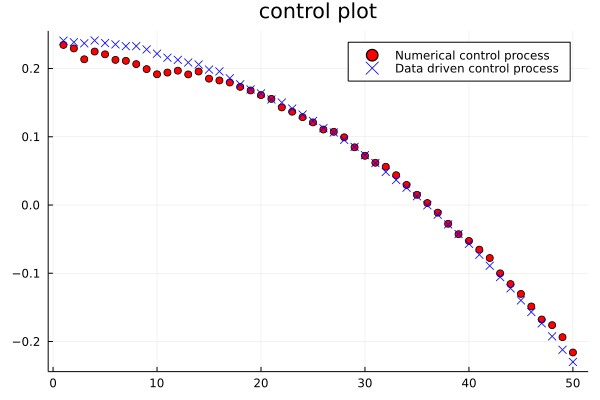

In [132]:
pp=scatter(ccvec,color="red",label="Numerical control process")
scatter!(pp,ctrlp1,markershape=:xcross,markercolor="blue",label="Data driven control process")
title!("control plot")

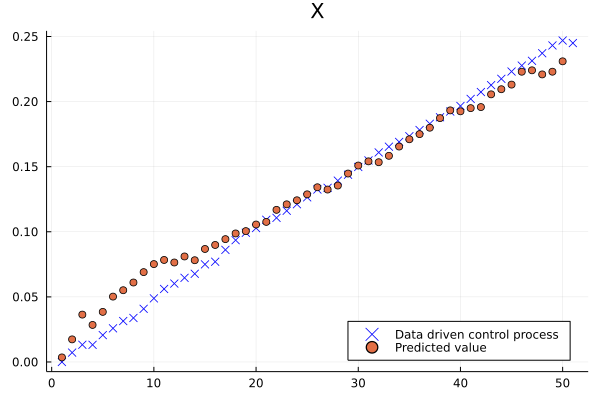

In [133]:
xpp=scatter(p2,legend=:bottomright,markershape=:xcross,markercolor="blue",label="Data driven control process")
scatter!(xpp,xfilter_unob[1:NT],label="Predicted value")
title!("X")

### Direct observation

uu1,ccvec1=particleF2(p2,timeVec);
xfilter=mean(uu1,dims=2)[:,1];

pp=scatter(ccvec1,color="red",label="Numerical control process")
scatter!(pp,ctrlp1,markershape=:xcross,markercolor="blue",label="Data driven control process")
title!("control plot")

xpp=scatter(p2,legend=:bottomright,markershape=:xcross,markercolor="blue",label="Data driven control process")
scatter!(xpp,xfilter[1:NT],label="Predicted value")
title!("X")

In [385]:
#Ures=optimize_loc(Xcloud,timeVec);

In [190]:
#tempres=sweep(50000,timeVec,Xcloud);
#ttp=optimize_loc(Xcloud,timeVec)

In [191]:
#pp=plot(uctrl)
#scatter!(pp,ttp)